# Image Preprocessing and Feature Extraction
Data preprocessing is important task in any computer vision. To get precise results, some
background noise should be removed before extraction of features. 
*   So first the RGB image is converted to greyscale
*   Gaussian filter is used for smoothening of the
image
*   Otsu’s thresholding algorithm is implemented to binaries the image
*   Morphological transform is applied on binarised image to close the small holes in the
foreground part
*  The bitwise AND operation on
binarised image and original color image is performed to get RGB image of segmented
leaf
*  Now after image segmentation shape, texture and color features are extracted from
the image. By using contours, area of the leaf and perimeter of the leaf is calculated.
Contours are the line that joins all the points along the edges of objects having same
color or intensity. Mean and standard deviation of each channel in RGB image is also
estimated.
*   To obtain amount of green color in the image, image is first converted to
HSV color space and we have calculated the ratio of number of pixels having pixel
intensity of hue (H) channel in between 30 and 70 and total number of pixels in one
channel. Non green part of image is calculated by subtracting green color part from 1.

After extracting color features from the image, we have extracted texture features from
grey level co-occurrence matrix (GLCM) of the image

GLCM is the spacial relationship of pixels in the image. Extracting texture features
from GCLM is one of the tradition method in computer vision. We have extracted
following features from GCLM:
*   Contrast
*   Dissimilarity
*   Homogeneity
*   Energy
*   Correlation

After extracting all the features from all the images in the dataset, feature selection task
is performed.

<img src="https://www.researchgate.net/publication/352643083/figure/fig2/AS:1037428873768962@1624353726703/Steps-for-data-preprocessing-and-feature-extraction.ppm" width="400" height="500">





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import greycomatrix, greycoprops
from matplotlib import pyplot as plt
%matplotlib inline
from os import listdir
from os.path import isfile, join

## Function to Create a new dataframe

In [ ]:
def create_empty_df():
  col = ['area', 'perimeter', 'red_mean', 'green_mean', 'blue_mean', 'f1', 'f2', 'red_std', 'green_std', 'blue_std', 'f4', 'f5', 'f6', 'f7', 'f8', 'label']
  df = pd.DataFrame(columns = col)
  return df

## Function to Extract the features

In [ ]:
def feature_extractor(filename):
  '''
  input params:
  filename : path of the file that we want to process

  output params:
  l: feature vector
  '''

  try:
    main_img = cv2.imread(filename)
    img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB) #converts an input image from one color space to another.
  except:
    return "Invalid"
  
  #Preprocessing

  gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #Grayscale conversion
  blur = cv2.GaussianBlur(gs, (25,25), 0) #Gaussian Filter: convolves the source image with the specified Gaussian kernel
  ret_otsu, im_bw_otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) # Otsu's Thresholding
  kernel = np.ones((25,25), np.uint8)
  closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel) #perform advanced morphological transformations using an erosion and dilation as basic operations.

  #Shape features
  contours, _ = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnt = contours[0]
  M = cv2.moments(cnt)
  area = cv2.contourArea(cnt)
  if area==0:
    return "Invalid"
  perimeter = cv2.arcLength(cnt,True)

  current_frame = main_img
  filtered_image = closing/255

  #Elementwise Multiplication of range bounded filtered_image with current_frame
  current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 0] = np.multiply(current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 0], filtered_image) #B channel
  current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 1] = np.multiply(current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 1], filtered_image) #G channel
  current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 2] = np.multiply(current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 2], filtered_image) #R channel

  img = current_frame

  #Color features
  red_channel = img[:,:,0]
  green_channel = img[:,:,1] #show the intensities of green channe
  blue_channel = img[:,:,2]

  red_mean = np.mean(red_channel)
  green_mean = np.mean(green_channel)
  blue_mean = np.mean(blue_channel)

  #standard deviation for colour feature from the image.    
  red_std = np.std(red_channel)
  green_std = np.std(green_channel)
  blue_std = np.std(blue_channel)
  
  #amt.of green color in the image
  gr = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  boundaries = [([30,0,0],[70,255,255])]
  for (lower, upper) in boundaries:
    mask = cv2.inRange(gr, (36, 0, 0), (70, 255,255))
    ratio_green = cv2.countNonZero(mask)/(img.size/3)
    f1=np.round(ratio_green, 2)

  #amt. of non green part of the image   
  f2=1-f1

  #Texture features using grey level cooccurance matrix
  img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  g=greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])

  #with the help of glcm find the contrast
  contrast = greycoprops(g, 'contrast')
  f4=contrast[0][0]+contrast[0][1]+contrast[0][2]+contrast[0][3]
  #[0][3] represent no. of times grey level 3 appears at the right of 0

  #with the help of glcm find the dissimilarity 
  dissimilarity = greycoprops(g, prop='dissimilarity')
  f5=dissimilarity[0][0]+dissimilarity[0][1]+dissimilarity[0][2]+dissimilarity[0][3]

  #with the help of glcm find the homogeneity
  homogeneity = greycoprops(g, prop='homogeneity')
  f6=homogeneity[0][0]+homogeneity[0][1]+homogeneity[0][2]+homogeneity[0][3]

  #with the help of glcm find the energy
  energy = greycoprops(g, prop='energy')
  f7=energy[0][0]+energy[0][1]+energy[0][2]+energy[0][3]

  #with the help of glcm find the correlation
  correlation = greycoprops(g,prop= 'correlation')
  f8=correlation[0][0]+correlation[0][1]+correlation[0][2]+correlation[0][3]

  l = [area, perimeter, red_mean, green_mean, blue_mean,
         f1, f2, red_std, green_std, blue_std,
        f4,f5,f6,f7,f8]
  
  return l

## Function to Process one folder

In [ ]:
def process_folder(folderpath, df_f, label_f):
  '''
  input params:
  folderpath : Path of the folder that we want to process
  df_f = dataframe for specific disease
  label_f : label corresponding to the specific disease

  Output params:
  df_f = Dataframe consisting processed vectors
  '''
  imagelist = os.listdir(folderpath) #stores all the imagepaths in the python list
  for image in imagelist:
    imagepath = os.path.join(folderpath, image)
    im_feature = feature_extractor(imagepath)
    if im_feature == "Invalid":
      continue
    im_feature.append(label_f) #append label to feature vector
    df_f.loc[len(df_f)] = im_feature
    if len(df_f)%500 == 0:
      print(len(df_f))

  return df_f

## Function to Process one plant

In [ ]:
def process_plant(folderpaths, labels, savepath):
  '''
  input params:
  folderpaths : List of the folderpaths for specific Plant
  labels : List of labels 
  savepath : Path to export datasheet

  Output params:
  None
  '''
  datasheet = create_empty_df()
  for i in range(len(folderpaths)):
      datasheet = process_folder(folderpaths[i],datasheet,labels[i])

  datasheet.to_excel(savepath)

  return None

## Data Preprocessing


In [ ]:
global_folder = '/content/drive/MyDrive/Tomato-Leaf-Disease-Detection/plantvillage/'
folderpaths = [global_folder+ 'Tomato___healthy',
              global_folder+ 'Tomato___Bacterial_spot',
              global_folder+ 'Tomato___Early_blight',
              global_folder+ 'Tomato___Late_blight',
              global_folder+ 'Tomato___Leaf_Mold',
              global_folder+ 'Tomato___Septoria_leaf_spot',
              global_folder+ 'Tomato___Spider_mites Two-spotted_spider_mite',
              global_folder+ 'Tomato___Target_Spot',
              global_folder+ 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
              global_folder+ 'Tomato___Tomato_mosaic_virus'
              ]

labels = [0,1,2,3,4,5,6,7,8,9]
savepath = '/content/drive/MyDrive/Tomato-Leaf-Disease-Detection/tomato.xlsx'
process_plant(folderpaths, labels, savepath)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000


# Data cleaning and Feature selection
Feature selection is an important step in all machine learning problems. In this project
we are selecting the features on the basis of correlation of variables with target variable.

For example:

The
correlation of feature green part of leaf (f1) and green part of leaf (f2) is very high (1)
which means both variables are dependent on each other. So we have dropped one of
them (f2). Now for apple disease prediction, less correlated features such as green
channel mean, red channel standard deviation, blue channel standard deviation,
dissimilarity (f5) and correlation (f8) will not contribute too much in model
development. So we have dropped these variables also. After feature selection, the data
is now parsed to machine learning classifiers to find the patterns in the data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
raw_data = pd.read_excel('/content/drive/MyDrive/Tomato-Leaf-Disease-Detection/tomato.xlsx')

In [ ]:
raw_data.dtypes

Unnamed: 0      int64
area          float64
perimeter     float64
red_mean      float64
green_mean    float64
blue_mean     float64
f1            float64
f2            float64
red_std       float64
green_std     float64
blue_std      float64
f4            float64
f5            float64
f6            float64
f7            float64
f8            float64
label           int64
dtype: object

In [ ]:
raw_data.drop(['Unnamed: 0'], axis = 1, inplace=True)

In [ ]:
raw_data.columns

Index(['area', 'perimeter', 'red_mean', 'green_mean', 'blue_mean', 'f1', 'f2',
       'red_std', 'green_std', 'blue_std', 'f4', 'f5', 'f6', 'f7', 'f8',
       'label'],
      dtype='object')

In [ ]:
#Compute pairwise correlation of columns, excluding NA/null values
raw_data.corr()

,area,perimeter,red_mean,green_mean,blue_mean,f1,f2,red_std,green_std,blue_std,f4,f5,f6,f7,f8,label
area,1.000000,0.824052,0.463559,0.496858,0.468154,0.377099,-0.377099,0.148208,0.069508,0.061543,-0.029870,0.140127,-0.582346,-0.622478,0.132690,-0.007389
perimeter,0.824052,1.000000,0.282385,0.282851,0.279706,0.171505,-0.171505,0.174014,0.120693,0.133698,0.036060,0.127054,-0.342144,-0.350593,0.088076,-0.036776
red_mean,0.463559,0.282385,1.000000,0.899398,0.929280,0.296912,-0.296912,0.789214,0.535615,0.592054,0.141778,0.296304,-0.778110,-0.802047,0.316459,-0.088513
green_mean,0.496858,0.282851,0.899398,1.000000,0.970695,0.539939,-0.539939,0.639749,0.643678,0.594371,0.059904,0.208884,-0.811103,-0.868311,0.424509,0.105265
blue_mean,0.468154,0.279706,0.929280,0.970695,1.000000,0.387317,-0.387317,0.706749,0.634722,0.673809,0.124303,0.254413,-0.773868,-0.828246,0.363488,0.067949
f1,0.377099,0.171505,0.296912,0.539939,0.387317,1.000000,-1.000000,0.098369,0.340027,0.120166,0.143307,0.290583,-0.614067,-0.595896,0.091840,0.264160
f2,-0.377099,-0.171505,-0.296912,-0.539939,-0.387317,-1.000000,1.000000,-0.098369,-0.340027,-0.120166,-0.143307,-0.290583,0.614067,0.595896,-0.091840,-0.264160
red_std,0.148208,0.174014,0.789214,0.639749,0.706749,0.098369,-0.098369,1.000000,0.765816,0.854889,0.468266,0.506135,-0.509586,-0.453983,0.122595,-0.129064
green_std,0.069508,0.120693,0.535615,0.643678,0.634722,0.340027,-0.340027,0.765816,1.000000,0.916546,0.415096,0.413187,-0.416715,-0.371377,0.251888,0.146535
blue_std,0.061543,0.133698,0.592054,0.594371,0.673809,0.120166,-0.120166,0.854889,0.916546,1.000000,0.505633,0.498900,-0.409325,-0.351427,0.134781,0.037013


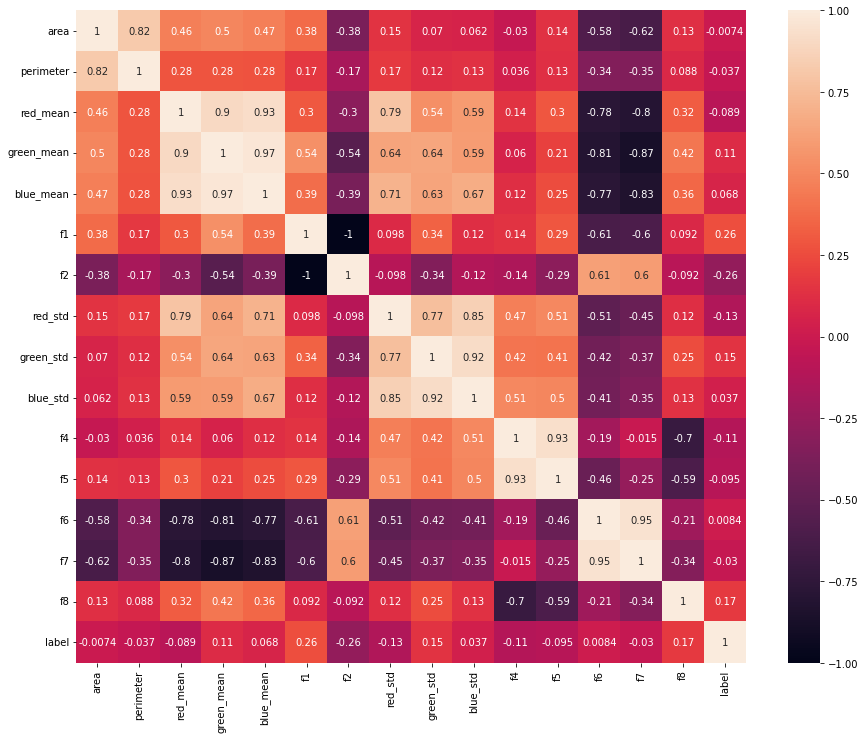

In [ ]:
#Visualize correlation matrix by using heatmap
plt.figure(figsize=(15,12))
sns.heatmap(raw_data.corr(), annot=True)
plt.show()

**Insights:**
Less correlated features are:
*   green channel mean
*   blue channel mean
*   green channel std
*   f4
*   f5
*   f6
*   f7
*   f8

Also f1 and f2 are mutually relative. So one of them can be removed






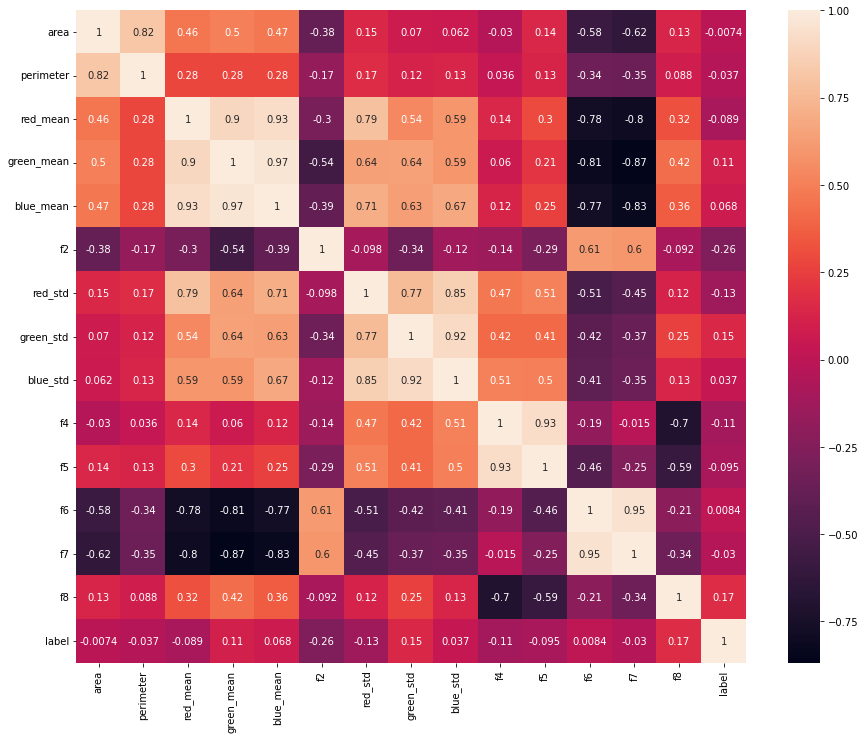

In [ ]:
cleaned_data = raw_data.drop(['f1'], axis=1, inplace=False)
#Visualize correlation matrix after drop feature f1
plt.figure(figsize=(15,12))
sns.heatmap(cleaned_data.corr(), annot=True)
plt.show()

In [ ]:
#Remove missing values N/A
cleaned_data = cleaned_data.dropna()
#Shape of raw_data
print('Shape of raw_data: ', raw_data.shape)
#Shape of cleaned_data
print('Shape of cleaned_data: ', cleaned_data.shape)

Shape of raw_data:  (14463, 16)
Shape of cleaned_data:  (14463, 15)


#Implementing classifier and Evaluation

## Using Random forest classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df = cleaned_data.reset_index()

In [ ]:
X = df.drop(['index','label'], axis = 1, inplace=False)
y = df['label']
print(X.shape)
print(y.shape)

(14463, 14)
(14463,)


In [ ]:
!pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 8.7 MB/s 


In [ ]:
# Optimization
import xlsxwriter
model_params = {
    'RF':{
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [1, 5, 10, 12, 15, 17,20, 30, 40, 50, 60, 70],
            'criterion': ['gini','entropy'],
            'max_depth': [5,10,15],
            'max_features': ['auto', 'sqrt', 'log2']
                }
        },
}
for model_name, mp in model_params.items():
    print(model_name)
    clf = GridSearchCV(mp['model'], mp['params'], cv=5)
    clf.fit(X, y)
    df = pd.DataFrame(clf.cv_results_)
    print("Best Params:", clf.best_params_)
    print("Best Score:", clf.best_score_)
    filepath = '/content/drive/MyDrive/Tomato-Leaf-Disease-Detection/gridSearch/' + str(model_name) +'.xlsx'
    writer = pd.ExcelWriter(filepath, engine='xlsxwriter')
    df.to_excel(writer, sheet_name=model_name)
    writer.save()

RF
Best Params: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 60}
Best Score: 0.7078061510614404


In [ ]:
k = 5
kf = KFold(n_splits=k, random_state=9, shuffle = True)

model = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)

acc_score = []

for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    #model = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)            # classification
    acc = accuracy_score(pred_values , y_test)     # Classification

    #acc = model.score(X_test,y_test)                # Regression
    
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('Score of each fold - {}'.format(acc_score))
print('Avg Score : {}'.format(avg_acc_score))

Score of each fold - [0.7054960248876598, 0.7089526443138611, 0.697200138264777, 0.6988243430152143, 0.6981327800829875]
Avg Score : 0.7017211861129


#Implementing the k Nearest Neighbours (kNN) classifier

In [ ]:
from sklearn import neighbors, datasets
clf = neighbors.KNeighborsClassifier(n_neighbors = 10, p = 2, weights = 'distance')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Print results for 20 test data points:")
print("Predicted labels: ", y_pred[:])
print("Ground truth    : ", y_test[:])


Print results for 20 test data points:
Predicted labels:  [0 1 0 ... 1 8 1]
Ground truth    :  0        0
3        0
10       0
11       0
12       0
        ..
14449    9
14450    9
14451    9
14457    9
14461    9
Name: label, Length: 2892, dtype: int64


In [ ]:
from sklearn.metrics import accuracy_score

print("Accuracy of 10NN (1/distance weights): %.2f %%" %(100*accuracy_score(y_test, y_pred)))

Accuracy of 10NN (1/distance weights): 42.39 %


**K-fold Cross validation accuracy:**
0.7059997530308548

###ROC Curve

In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


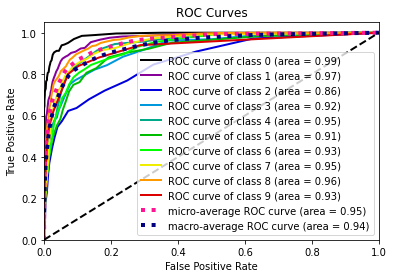

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = y_test
y_probas = model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


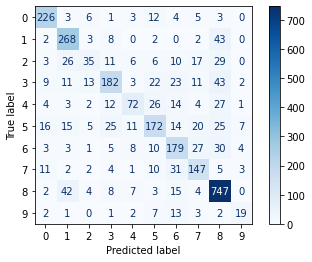

In [ ]:
from sklearn.metrics import plot_confusion_matrix
y_pred = model.predict(X_test)
plot_confusion_matrix(model, X_test, y_test, values_format = 'd',cmap = 'Blues',display_labels = ['0','1','2','3','4','5','6','7','8','9'])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, labels=[0,1,2,3,4,5,6,7,8,9]))

              precision    recall  f1-score   support

           0       0.81      0.86      0.84       263
           1       0.72      0.82      0.76       328
           2       0.49      0.24      0.33       143
           3       0.71      0.57      0.63       319
           4       0.64      0.44      0.52       165
           5       0.64      0.55      0.59       310
           6       0.59      0.66      0.62       270
           7       0.61      0.68      0.64       216
           8       0.78      0.90      0.84       832
           9       0.53      0.38      0.44        50

    accuracy                           0.71      2896
   macro avg       0.65      0.61      0.62      2896
weighted avg       0.70      0.71      0.70      2896



**F1 score:**
0.71

###Deployment

In [ ]:
from sklearn.ensemble import RandomForestClassifier
lm = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)
lm.fit(X,y)
print('Training Score: ',lm.score(X,y))

Training Score:  0.9957191189670649


In [ ]:
lm.feature_importances_

array([0.05201146, 0.04578918, 0.08141989, 0.05787966, 0.05748563,
       0.08672721, 0.10502281, 0.07317731, 0.06512543, 0.08651907,
       0.07830558, 0.05269637, 0.0573802 , 0.10046019])

In [ ]:
import pickle
filename = '/content/drive/My Drive/Colab Notebooks/Project_Subjects/image processing/tomato_model.sav'
pickle.dump(lm, open(filename, 'wb'))

filename = '/content/drive/My Drive/Colab Notebooks/Project_Subjects/image processing/tomato_model.sav'
dep_model = pickle.load(open(filename, 'rb'))
print(dep_model.score(X,y))

0.9957191189670649
